# Path Planning with Gaussian Processes

In [1]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import tueplots
from tueplots import bundles
plt.rcParams.update(bundles.neurips2022())

# Scientific computing
import numpy as np
import probnum
import itergp
import pykeops
pykeops.set_verbose(False)

## Learning to Navigate

Imagine you've landed a robot on a remote planet and are now trying to explore that planet to find potential life forms. The spaceship which landed your robot is still orbiting the planet and taking measurements of the elevation to enable you to navigate on the planet.

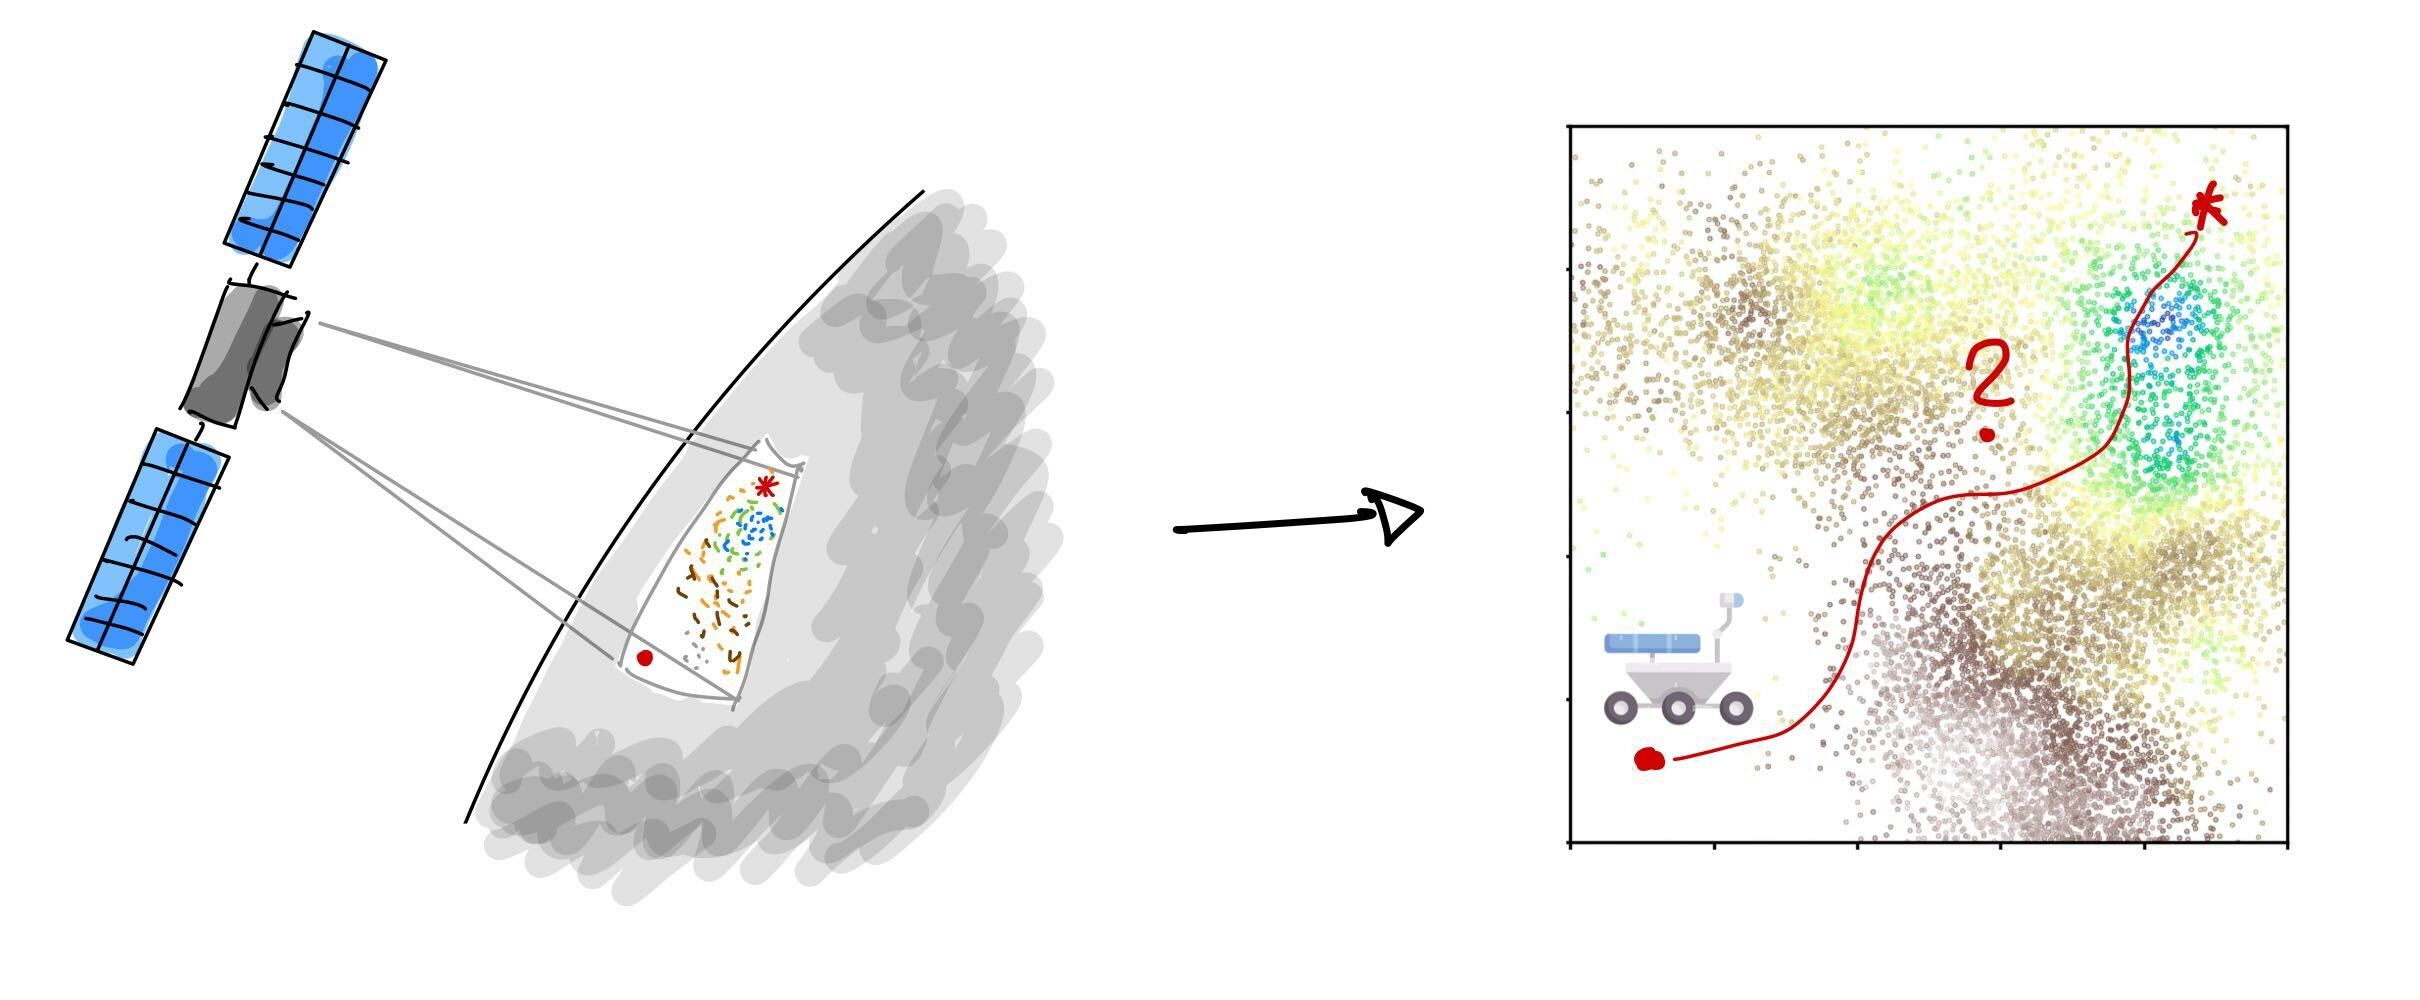

In [41]:
from IPython.display import Image

Image(filename="learning_to_plan_illustration.jpg")


### Landscape Data

In [62]:
from landscapes import generate_landscape
from dataset import Dataset

# True landscape unknown to our robot
landscape_fn = generate_landscape(seed=0)

# Satellite measurements
num_train_data = 10000
train_data = Dataset(landscape_fn, num=num_train_data)
train_data.X.shape

(10000, 2)

To give you an idea, on the left is a simulated landscape, versus the actual data you obtain is on the right.

In [40]:
%matplotlib inline
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Simulated landscape
    simulated_landscape_fn = generate_landscape(seed=42)
    xs = np.linspace(0, 1.0, 100)
    ys = np.linspace(0, 1.0, 100)
    X, Y = np.meshgrid(xs, ys)
    Z = simulated_landscape_fn(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    axs[0].contourf(X, Y, Z, levels=50, cmap="terrain")

    # Simulated landscape data
    simulated_train_data = Dataset(simulated_landscape_fn, num=num_train_data)
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    axs[1].scatter(simulated_train_data.X[0:n_subset, 0], simulated_train_data.X[0:n_subset, 1], c=simulated_train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Unknown landscape")
    axs[1].set(title="Available data")
    plt.show()

### Path Planning

Now to efficiently explore the remote planet we want to move with our robot to a certain location. However, we only have limited energy resources available and need to take a path that is efficient to drive along.

In [4]:
startpoint = np.asarray([0.1, 0.1])
endpoint = np.asarray([0.9, 0.9])

You can plan two different paths in the widget below and measure their energy cost. Try to find an energy efficient path simply from the measurement data. 

*Hint:* You can add points by clicking on the corresponding path in the legend and remove points by right-clicking near the point to be removed.

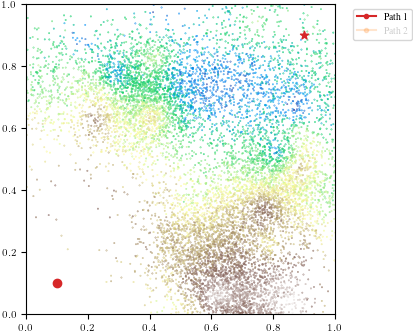

In [42]:
%matplotlib widget
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()

    # Landscape data
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    ax.scatter(train_data.X[0:n_subset, 0], train_data.X[0:n_subset, 1], c=train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Plot start and endpoints
    ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
    ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(ax, path_list, markers=[".", "."], colors=["C3", "C1"], linestyle= "-")
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})
    
    # Plot settings
    ax.set_aspect("equal")
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.show()


In [45]:
# Create paths and add endpoint to each path
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)


In [46]:
from cost_functions import movement_cost

# TODO: this is actually not known! Only after driving the path.
print(f"Energy cost of path 1: {movement_cost(path1, landscape=landscape_fn): 4.4f}")
print(f"Energy cost of path 2: {movement_cost(path2, landscape=landscape_fn): 4.4f}")


Energy cost of path 1:  83.8535
Energy cost of path 2:  60.1875


## Gaussian Processes

Path planning is quite difficult simply from the datapoints. Especially, because in practice we *do not know the real energy cost*. Let's try to learn the surface of the remote planet from the data instead. Since we want to use energy conservatively, we need a model with uncertainty, to avoid unknown hills or valleys. We'll use a Gaussian process for this purpose.

## Scaling to Large Datasets

In [64]:
from probnum import randvars, linops
from probnum.randprocs import mean_fns
from itergp.kernels import Matern
from itergp import GaussianProcess, methods

input_shape=(2,)

# GP prior
mean_fn = mean_fns.Zero(input_shape)
kernel = Matern(input_shape, lengthscale=0.2, nu=3.5)

gp = GaussianProcess(mean_fn, kernel)

# Likelihood
sigma_sq = 0.1
noise = randvars.Normal(
    mean=np.zeros_like(train_data.y),
    cov=linops.Scaling(sigma_sq, shape=(num_train_data, num_train_data)),
)

In [59]:
# Fit GP on >100000 data points

# Need kernel matrix -> 149 GiB ~= 160 GB
Khat = kernel.matrix(train_data.X) + sigma_sq * np.eye(num_train_data)

MemoryError: Unable to allocate 149. GiB for an array with shape (100000, 100000, 2) and data type float64

In [60]:
# What if we tried Cholesky on smaller matrix?
n_smaller = 20000 # largest matrix still fitting into memory
Khat = kernel.matrix(train_data.X[0:n_smaller]) + sigma_sq * np.eye(n_smaller)
L = np.linalg.cholesky(Khat)

## Computation-Aware Inference

In [65]:
# Accurate images on satellite around Mars, but communication with earth is slow and hardware is limited on satellite / robot. Need fast inference with little computation time.

# iterative gp posterior
gp_post = gp.condition_on_data(train_data.X, train_data.y, noise, approx_method=methods.Cholesky(maxrank=200))

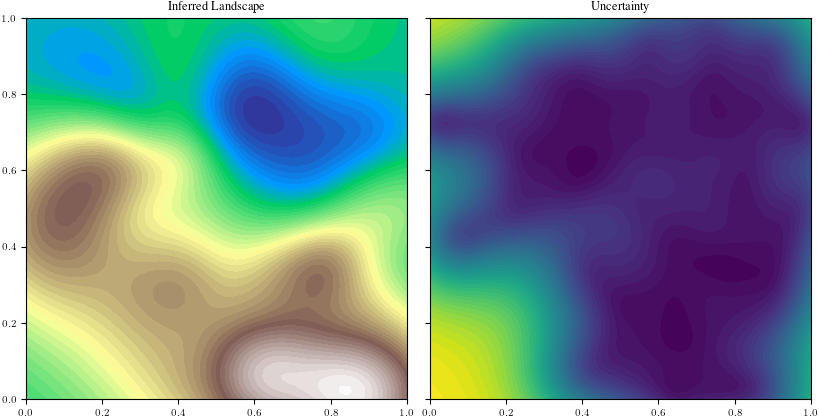

In [66]:
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.5)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # GP prediction
    xs = np.linspace(0, 1.0, 100)
    ys = np.linspace(0, 1.0, 100)
    X, Y = np.meshgrid(xs, ys)
    X_pred = np.vstack([X.ravel(), Y.ravel()]).T
    y_pred = gp_post.mean(X_pred)

    # Evaluate landscape function for plotting
    axs[0].contourf(X, Y, y_pred.reshape(X.shape), cmap="terrain", levels=50)

    # Uncertainty
    axs[1].contourf(
        X, Y, gp_post.std(X_pred).reshape(X.shape), cmap="viridis", levels=50
    )

    # Plot settings
    axs[0].set_title("Inferred Landscape")
    axs[1].set_title("Uncertainty")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)
    plt.show()


### Design Your Own Approximation Method

In [ ]:
# Use clicker to let people choose observation points (and their weighing through an array later on)?

### Belief over Energy Cost of Path



In [ ]:
# Approximate path integral along chosen path => Gaussian belief over elevation change since linear combination of variables.
# Problem: Cost along path will be non-linear as a function of landscape